Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.0_gsyn=1.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.002_Gc=0.7_ggap=1.0_gsyn=1.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.875_gsyn=1.5
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.263


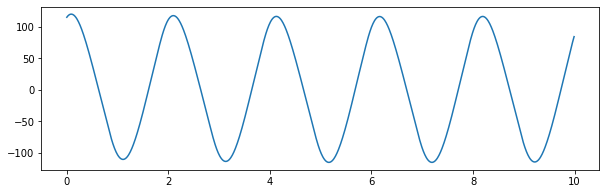

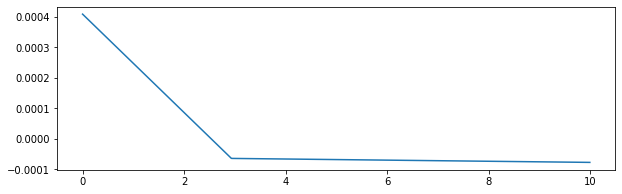

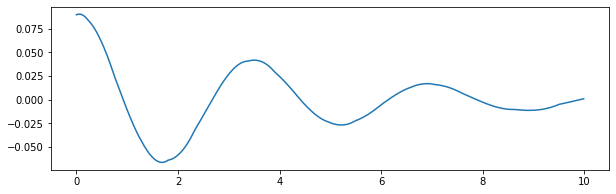

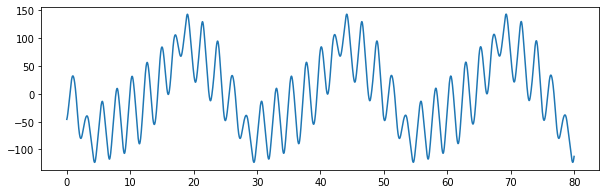

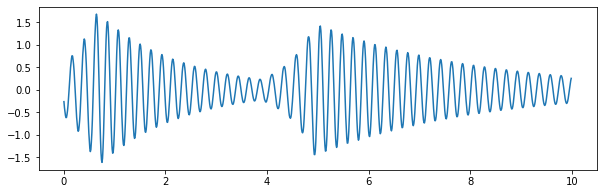

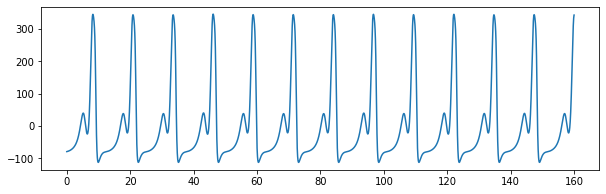

In [7]:
import numpy as np
import pandas as pd
import time
from neural_model import NeuralModel
from simulation_functions import *
from sklearn.decomposition import PCA
from util.analysis_util import *
from util.neuron_metadata import *
from util.plot_util import *

neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json('data/chem.json')
last_n_percent = 0.50

def get_dom_mode(ggap, gsyn, C = 0.015, Gc = 0.1):
  all_dynamics = simulate_until_stable(
    C = C,
    Gc = Gc,
    ggap = ggap,
    gsyn = gsyn)
  n = all_dynamics.shape[0]
  last_dynamics = all_dynamics[-int(last_n_percent * n):,:]
  pca = PCA(n_components = 1)
  # Perform mean-centering before PCA
  X = last_dynamics - last_dynamics.mean(axis= 0)
  projected_X = pca.fit_transform(last_dynamics)
  return projected_X[:,0]

def plot_ts(ts):
  times = np.arange(0, ts.shape[0] * 0.01 , 0.01)
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
  ax.plot(times, ts)
  
  
ts_simple_oscillation = get_dom_mode(ggap = 1.0, gsyn = 1.0)
ts_stable_node = get_dom_mode(ggap = 0.0, gsyn = 0.0)
ts_stable_focus = get_dom_mode(C = 0.002, Gc = 0.7, ggap = 1.0, gsyn = 1.0)
ts_nested_oscillation_mean_shift = get_dom_mode(ggap = 0.875, gsyn = 1.5)
ts_nested_oscillation_amplitude_shift = get_dom_mode(ggap = 0.0789, gsyn = 1.1842)
ts_spike = get_dom_mode(ggap = 0.1579, gsyn = 1.2632)

plot_ts(ts_simple_oscillation)
plot_ts(ts_stable_node)
plot_ts(ts_stable_focus)
plot_ts(ts_nested_oscillation_mean_shift)
plot_ts(ts_nested_oscillation_amplitude_shift)
plot_ts(ts_spike)